In [1]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import at
from at import plot
from math import pi

from functions import *
from PID import *
from rings.p3_elements_v24_c4l import *
# ring = load_mat('rings/hmba.mat')

In [8]:
help(at.lattice_pass)

Help on class Lattice in module at.lattice.lattice_object:

class Lattice(builtins.list)
 |  Lattice(*args, **kwargs)
 |  
 |  Lattice object
 |  An AT lattice is a sequence of AT elements.
 |  A Lattice accepts extended indexing (as a numpy ndarray).
 |  
 |  Lattice attributes;
 |      name        Name of the lattice
 |      energy      Particle energy
 |      periodicity Number of super-periods to describe the full ring
 |  
 |  Lattice(elems, **params)     Create a new lattice object
 |  
 |      INPUT
 |          elems:          any iterable of AT elements
 |  
 |      KEYWORDS
 |          iterator=None   Custom iterator (see below)
 |          scan=False      Scan elements, looking for energy and periodicity
 |          name            Name of the lattice
 |          energy          Energy of the lattice
 |          periodicity     Number of periods
 |          *               all other keywords will be set as Lattice attributes
 |  
 |  To reduce the inter-package dependencies, 

In [2]:
# Lattice creation
lat = at.Lattice(ring, energy=6.e9)
lat.radiation_off()

# Obtaining correctors and BPMs Ids
cor_ids = at.get_refpts(lat, at.elements.Corrector)
bpm_ids = at.get_refpts(lat, at.elements.Monitor)

# BPMs positions
s_pos = lat.get_s_pos(bpm_ids)

# Obtain revolution frequency of the full ring
# rf = lat.get_revolution_frequency()

In [3]:
# Calculation of response matrix
# R = response_matrix(lat, 0.0001)
# np.savetxt('rings/rm_p3_elements_v24_c4l.out', R, fmt='%1.20f')
R = np.loadtxt('rings/rm_p3_elements_v24_c4l.out')

RMS:  0.010609522628322637


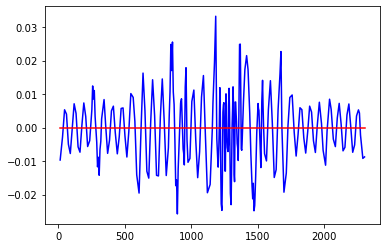

In [4]:
%matplotlib inline

import random

# Add error
quad_ids = at.get_refpts(lat, elements.Quadrupole)
at.shift_elem(lat[quad_ids[0]], deltax=0.01, deltaz=0.0, relative=False)
# for cor in cor_ids:   
#     lat[cor].KickAngle  = [random.uniform(-1, 1)/100000, 0]


orbit0, orbit = at.find_orbit(lat, refpts = bpm_ids)
x = orbit[:,0]
y = orbit[:,2]
print('RMS: ', np.sqrt(np.mean(np.square(x))))
plt.plot(s_pos, x, 'b-')
plt.plot(s_pos, y, 'r-')

# Time domain model

Loop  1  RMS:  0.0011862600447555159
Loop  2  RMS:  0.00028971141184161664
Loop  3  RMS:  0.0002341455925582547
Loop  4  RMS:  0.00023257550491894682
Loop  5  RMS:  0.0002324410403904359


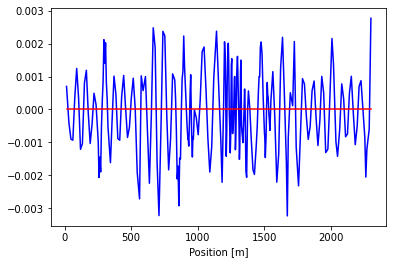

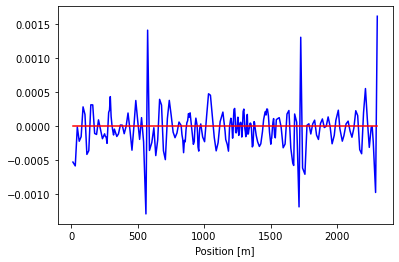

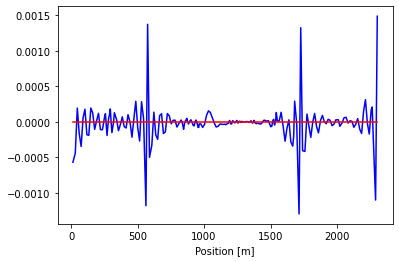

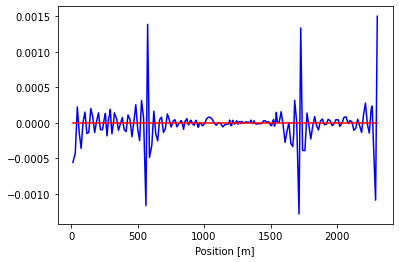

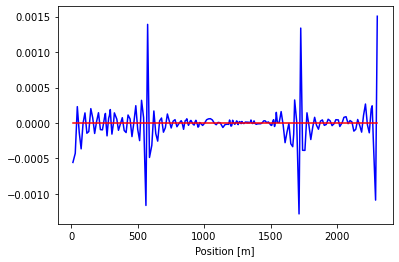

In [5]:
%matplotlib inline

# PID controller setup
controller = PID()
controller.SetKp(0)
controller.SetKi(1)
controller.SetKd(0)

# Simulation setup 
reference_signal = np.zeros(len(bpm_ids))
n_sv = 80
nturns = 5

for t in range(1, nturns+1):
    # Calculation of error
    error = reference_signal - x

    # PID controller
    c_out, dt = controller.GenOut(error, t)

    # Solve SVD
    Rinv = svd_solve(R, n_sv)
    cs = np.dot(np.transpose(Rinv), c_out)
    
    # Changing correctors kick angle
    change_correctors_kick_angle(lat, cs)
    
    # Calculate new orbit and plot
    orbit0, orbit = at.find_orbit(lat, refpts = bpm_ids)
    x = orbit[:,0]
    y = orbit[:,2]
    print('Loop ', t,' RMS: ', np.sqrt(np.mean(np.square(x))))
    plt.figure()
    plt.plot(s_pos, x, 'b-')
    plt.plot(s_pos, y, 'r-')
    plt.xlabel('Position [m]')

# Frequency domain model

In [10]:
    """
    The bloc diagram is the following:
                                
     r=0        +-------+    +---+    +---------+           +--------+           
      ---->(-)->| H_PID |--->| H |--->| H_delay |--->(+)--->| H_ring |---+---> orbit
            ^   +-------+    +---+    +---------+     ^     +--------+   |
            |                                         |                  |
            |                                       Error                |
            +------------------------------------------------------------+
    """

# Delay
Tau = 10
N = 100 # Order of aproximation
[num_pade, den_pade] = ct.pade(Tau, N)
H_Delay = ct.tf(num_pade, den_pade)

# PID controller transfer function
Kp = 10
Ti = 1
Td = 0
gamma = 0.1
H_PID_Controller = ct.series(ct.tf([Kp], [1]), ct.parallel(1, ct.tf([1], [Ti, 0]), ct.tf([Td, 0], [gamma*Td, 1])))

print(np.shape(at.find_m66(lat, refpts=range(len(lat)))))


(2,)


/home/jgnav/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


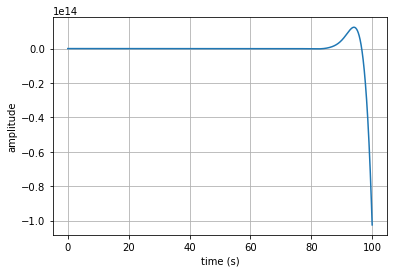

In [6]:
# # Obtaining correctors and BPMs Ids
# cor_ids = at.get_refpts(lat, at.elements.Corrector)
# bpm_ids = at.get_refpts(lat, at.elements.Monitor)

# lindata0, tune, chrom, lindata = at.linopt(lat, refpts = bpm_ids)

# plt.plot(lindata.s_pos, lindata['closed_orbit'][:, 0], 'b-')
# plt.plot(lindata.s_pos, lindata['closed_orbit'][:, 2], 'r-')

# Delay
Tau = 10
N = 20 # Order of aproximation
[num_pade, den_pade] = ct.pade(Tau, N)
H_Process_Delay = ct.tf(num_pade, den_pade)

# Process transfer function 
w = 1
d = 0.1
A = [[0, 1],
     [-w**2, -2*d]]
B = [[0], 
     [1]]
C = [1, 0]
D = 0
H_Process = ct.ss(A, B, C, D)
# H_Process = ct.tf([1],[1])
H_Process = ct.series(H_Process_Delay, H_Process)

# PID controller transfer function
Kp = 10
Ti = 1
Td = 0
gamma = 0.1
H_PID_Controller = ct.series(ct.tf([Kp], [1]), ct.parallel(1, ct.tf([1], [Ti, 0]), ct.tf([Td, 0], [gamma*Td, 1])))

# Closed loop transfer function
H = ct.series(H_PID_Controller, H_Process)
H = ct.feedback(H, 1, -1)

# Plot response
ts = np.linspace(0, 100, 100000)
t, y = ct.step_response(H, ts)

plt.plot(t, y)
plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.grid()

# # Delay
# Tau1 = 32
# Tau2 = 100
# Tau3 = 300
# N = 1 # Order of aproximation
# [num_pade1, den_pade1] = ct.pade(Tau1, N)
# [num_pade2, den_pade2] = ct.pade(Tau2, N)
# [num_pade3, den_pade3] = ct.pade(Tau3, N)
# H_Process_Delay = ct.tf([[num_pade1, [0.], [0.]],
#                          [[0.], num_pade2, [0.]],
#                          [[0.], [0.], num_pade3]],
#                         [[den_pade1, [1.], [1.]],
#                          [[1.], den_pade2, [1.]],
#                          [[1.], [1.], den_pade3]])

# # Process transfer function 
# A = [[0, 0, -8],
#      [1, 0, -14],
#      [0, 1, -7]]
# B = [[1, 2, 0],
#      [1, 0, 1],
#      [2, 1, 1]]
# C = [[1, 0, 0],
#      [0, 1, 0], 
#      [0, 0, 1]]
# sys = ct.ss(A, B, C, 0)
# H_Process = ct.ss2tf(sys)
# H_Process = ct.series(H_Process, H_Process_Delay)

In [ ]:
%matplotlib inline

# Time configuration 
fs = 150
ts = 1/fs
t_max = 3
t = np.arange(int(fs*t_max))/fs
N = int(fs*t_max)

# Perturbations
# perturbation_samples = spectrum_noise(lambda f: 1 / f**0, N, fs) 

# fmin=1e-3
# fmax=75
# perturbation_samples = sinesweep(t, fmin, fmax)

# fsin = 10
# amplitude = 1
# perturbation_samples = amplitude*np.sin(2*np.pi*t*fsin)

t0 = 0.1
perturbation_samples = np.piecewise(t, [t < t0, t >= t0], [0, 0.0001])

# TRANSFER FUNCTIONS
# Low pass filter 
wc = 2 * np.pi * 715
num_lp = [wc]
den_lp = [1, wc]

# PID controller
Kp = 0
Ki = 1
Kd = 0
num_pid, den_pid = PID_transfer_function(Kp, Ki, Kd)

# Simulation configuration
quad_offset = np.zeros((t.size, len(quad_ids)))
corr_str = np.zeros((t.size, len(cor_ids)))
corr_str_delay = np.zeros((t.size, len(cor_ids)))
orbit = np.zeros((t.size, len(bpm_ids)))
error = np.zeros((t.size, len(bpm_ids)))

reference_orbit = 0
rms = []
x_lp = np.zeros(len(cor_ids)*(len(den_lp)-1))
x_pid = np.zeros(len(bpm_ids)*(len(den_pid)-1))

# Delay configuration
loop_delay = 131e-3
delay_offset = math.ceil(loop_delay*fs) 

# Inverse of reponse matrix 
n_sv = 80
Rcinv = svd_solve(Rc, n_sv)

# Simulation
for n in tqdm(range(1, t.size)):
    # Error calculation
    error[n, :] = reference_orbit - orbit[n-1, :]

    # PID controller
    PID_out, x_pid = apply_f(num_pid, den_pid, error[n, :], x_pid, ts)

    # Correctors str
    corr_str[n, :] = np.dot(Rcinv.T, PID_out)

    # Apply delay
    if n >= delay_offset:
        corr_str_delay[n, :] = corr_str[n - delay_offset, :]

    # Correctors response
    filter_out, x_lp = apply_f(num_lp, den_lp, corr_str_delay[n, :], x_lp, ts)

    # Adding perturbation 
    quad_offset[n, :] = quad_offset[n, :] + perturbation_samples[n]

    # Orbit calculation
    # change_magnets_alignment(lat, perturbation_samples[n])
    # change_correctors_kick_angle(lat, filter_out)
    # out1, out2 = at.find_orbit4(lat, refpts=bpm_ids) 
    # orbit[n, :] = out2[:, 0]
    orbit[n, :] = np.dot(Rm.T, quad_offset[n, :]) + np.dot(Rc.T, filter_out)
    rms.append(np.sqrt(np.mean(np.square(orbit[n, :]))))